# Analysis of different modulation schemes in the AWGN channel

In this lab, we consider different modulation schemes (BPSK, QPSK, ASK4, QAM16), find their performance experimentally and compare the results with derived formulas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special
import math
import scipy.stats as stats

Consider AWGN (Additive white Gaussian noise) channel:
$y = x + z$, where $z \sim \mathcal{CN}(0,\,2\sigma^{2}) = \mathcal{CN}(0,\,N_0)$ - complex valued noise: $z = z_I + j z_Q$, $z_I, z_Q \sim \mathcal{N}(0,\,\sigma^{2})$

Thus, $N_0 = 2\sigma^2$ - noise power spectral density

Function **gen_noise** generates such noise given $\sigma$ in linear scale

In [2]:
# Generate complex-valued noise
def gen_noise(sigma):
    z_re = np.random.normal(0, 1) * sigma
    z_im = np.random.normal(0, 1) * sigma
    
    return z_re + 1j * z_im  # The total power is 2*sigma^2

Performance of different modulation schemes can be evaluated by finding dependency of Bit Error Rate (BER) on SNR. We can use Bernoulli trials to find this dependency experimentally.

Consider an experiment that evaluates the error probability $\hat{p}$, and every single $i$-th test returns either $\hat{p}^{(i)} = 0$ - if the error did not happen, or $\hat{p}^{(i)}=1$ - if the error happened.

Given $n$ independent tests, the resulting error variable $\hat{p} = \frac{1}{n}\sum_{i = 1}^n\hat{p}^{(i)}$

The relative error depends on the number of errors $n_e$ happened in the series of single tests:
$
\Delta\hat{p} = z\sqrt{\frac{\hat{p}(1 - \hat{p})}{n}} \Rightarrow \frac{\Delta \hat{p}}{\hat{p}} = \frac{z}{\sqrt{\hat{p}n}} = \frac{z}{\sqrt{n_e}},
$
where $z$ is a standard normal distribution quantile.

Thus, we can run single experiments until a required number of errors is not collected. Function **simulate()** does that given desired SNR range in dB (*snr_db_range*), desired number of errors *max_errors* and pointer to the function for running single experiment (*experiment_func*)

In [3]:
def simulate(snr_db_range, max_errors, experiment_func):
    p_e = np.zeros(snr_db_range.shape)
    n_points = p_e.shape[0]
    # Run simulations:
    for i in range(n_points):
        snr_db = snr_db_range[i]
        n_errors = 0.0
        n_experiments = 0.0
        while n_errors < max_errors:
            n_errors += experiment_func(snr_db)
            n_experiments += 1
        p_e[i] = n_errors / n_experiments
    
    return p_e

## BPSK - Binary Phase-Shift Keying

BPSK modulation corresponds to the following mapping of bits to the points on the constellation diagram:
$0 \rightarrow A,\;\;1 \rightarrow -A$

Let's choose $A=1$ so the average power of the signal is equal to $1$

In [4]:
BPSK = np.array([1,-1])
BPSK_bits = ["0","1"]

Create auxiliary function **plot_constellation()** for plotting constellation diagrams

In [5]:
def plot_constellation(constellation, bits, title):
    plt.figure(figsize=(10,6))
    plt.scatter(constellation.real, constellation.imag, s=100)
    plt.xlim([-abs(constellation).max()-0.5, abs(constellation).max()+0.5])
    plt.ylim([-abs(constellation).max()-0.5, abs(constellation).max()+0.5])
    for i, txt in enumerate(bits):
        plt.annotate(txt, (constellation.real[i]+0.15, constellation.imag[i]+0.15), size=20)
    plt.title(title)

Plot constellation diagram for BPSK

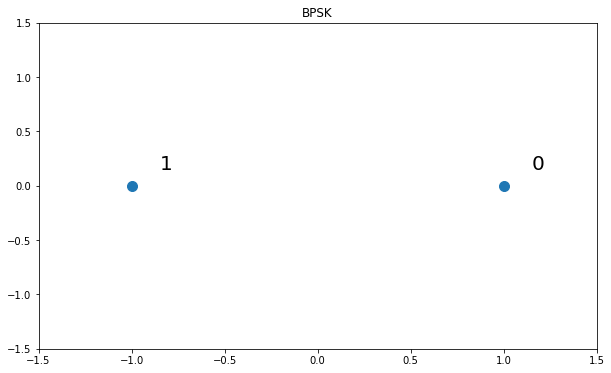

In [6]:
plot_constellation(BPSK, BPSK_bits, "BPSK")

Create function **one_run()** for running one experiment given constellation (*constellation*) and SNR in dB (*snr_db*)

In [7]:
def one_run(constellation, snr_db):    
    # Randomly select one point in constellation
    x = np.random.randint(0, len(constellation))
    # Convert to linear scale
    linear_snr = 10 ** (snr_db / 10)
    # Calculate spectral noise power given that average signal power is equal to 1
    N_0 = 1 / linear_snr
    # Find sigma: N_0 = 2*sigma^2, sigma = sqrt(N_0 / 2)
    sigma = np.sqrt(N_0 / 2)
    # Apply noise
    y = constellation[x]  + gen_noise(sigma)
    # Decode according to the principle of maximum likelihood
    x_hat = np.argmin(np.abs(y - constellation)**2)

    # Compute the number of occured errors
    n_errors = bin(x ^ x_hat).count('1')
    # Find the total number of transmitted bits
    n_transmitted_bits = np.log2(len(constellation))
    
    # return BER in this experiment - the number of errors divided by the total number of transmitted bits
    return n_errors / n_transmitted_bits

Carry out simulation for given range of SNR in dB

In [8]:
snr_range_BPSK = np.arange(-15, 8, 0.5)

p_e_BPSK = simulate(
    snr_range_BPSK,      # SNR values
    500,                  # Maximum error count
    lambda x: one_run(BPSK, x)  # Single test function
)

Let's derive theoretical equation for BER(SNR)

On the following pictures, there are two gaussian distributions: $f(x|s=1)$ - probability to receive $x$ when transmitted symbol is $1$, and $f(x|s=0)$ - probability to receive $x$ when transmitted symbol is $0$.

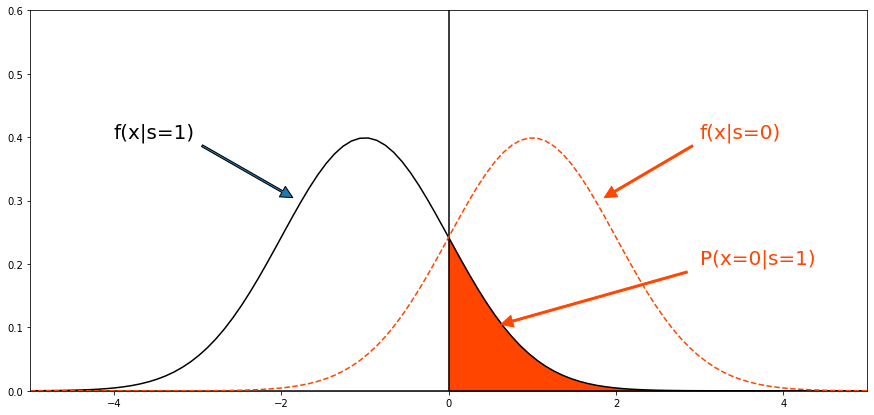

In [9]:
plt.figure(figsize=(15,7))
xmin = -5
xmax = 5
sigma = math.sqrt(1)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, -1, sigma), color="k")
plt.plot(x, stats.norm.pdf(x, 1, sigma), "--", color="orangered")
plt.vlines(0, 0, 0.6, "k")
plt.hlines(0, xmin, xmax, "k")

plt.ylim(0,0.6)
plt.xlim([xmin,xmax])

section = np.arange(0, 4, 1/20.)
plt.fill_between(section,stats.norm.pdf(section, -1, sigma), color="orangered")

plt.annotate('P(x=0|s=1)', xy=(0.5, 0.1), xytext=(3, 0.2), color='orangered',
            arrowprops=dict(shrink=0.05, width=2, color="orangered"), size=20)

plt.annotate('f(x|s=1)', xy=(-1.8, 0.3), xytext=(-4, 0.4),
            arrowprops=dict(shrink=0.05, width=2), size=20)

plt.annotate('f(x|s=0)', xy=(1.8, 0.3), xytext=(3, 0.4), color='orangered',
            arrowprops=dict(shrink=0.05, width=2, color='orangered'), size=20)
plt.show()

In BPSK, we make a desicion based on whether the real part $x$ of the received symbol is greater than $0$ or less, so the decision boundary is $x=0$

Thus, the error probability is the probability of $x=0$ given that the transmitted bit is $s$.

In the case of BPSK, the error probability is equivalent to BER and equal to the shaded area:

$BER = P(x=0|s=1) = \int_{0}^{+\infty} f(x|s=1) \,dx = \frac{1}{\sqrt{2\pi \sigma^2}} \int_{0}^{+\infty} exp(-\frac{(u+A)^2}{2\sigma^2})\,du = \Big[ \frac{u+A}{\sigma}=z, du = \sigma dz \Big] = \frac{1}{\sqrt{2\pi}}\int_{\frac{A}{\sigma}}^{+\infty} exp(-\frac{z^2}{2})\,dz = Q(\frac{A}{\sigma}),$

where $Q(x) = \frac{1}{\sqrt{2\pi}}\int_{x}^{+\infty} exp(-\frac{z^2}{2})\,dz$

Let's implement $Q(x)$ using [scipy.special.erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html).
According to datasheet, $special.erf(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} exp(-t^2)\,dt$.

It is well-known fact that $\frac{1}{\sqrt{\pi}}\int_{-\infty}^{+\infty} exp(-t^2)\,dt = 1$,
while $\frac{1}{\sqrt{\pi}}\int_{0}^{+\infty} exp(-t^2)\,dt = \frac{1}{2}$.

Therefore, $\frac{1}{2} - \frac{1}{2} special.erf(x) = \frac{1}{2} - \frac{1}{\sqrt{\pi}}\int_{0}^{x} exp(-t^2)\,dt = \frac{1}{\sqrt{\pi}}\int_{x}^{+\infty} exp(-t^2)\,dt = \Big[t=\frac{z}{\sqrt{2}}, dt=\frac{dz}{\sqrt{2}} \Big] = \frac{1}{\sqrt{2\pi}}\int_{\sqrt{2}x}^{+\infty} exp(-\frac{z^2}{2})\,dz = Q(\sqrt{2}x)$

and $Q(x) = \frac{1}{2} - \frac{1}{2} special.erf(\frac{x}{\sqrt{2}})$

In [10]:
def Q(x):
    return 0.5 - 0.5 * special.erf(x/np.sqrt(2))

$SNR = \frac{E_s}{N_0}$, where $E_s = A^2$ - average signal power, $N_0 = 2\sigma^2$ - noise power spectral density.

Therefore, $\frac{E_s}{N_0} = \frac{A^2}{2\sigma^2}$, $\frac{A}{\sigma} = \sqrt{\frac{2E_s}{N_0}}$.

Given that, $BER = Q(\frac{A}{\sigma}) = Q(\sqrt{\frac{2E_s}{N_0}})$

It is reasonable to plot dependency of BER on $\frac{E_b}{N_0}$ - energy per bit to noise power spectral density ratio.

Finally, $BER = Q(\sqrt{\frac{2E_b}{N_0}})$

In [11]:
def get_ber_BPSK(eb_no_db):
    eb_no_linear = 10 ** (eb_no_db / 10)
    return Q(np.sqrt(2*eb_no_linear))

Let's create function for convertion SNR to $\frac{E_b}{N_0}$ - energy per bit to noise power spectral density ratio

In [12]:
def snr_to_eb_no(snr, constellation):
    return snr - 10 * np.log10(np.log2(len(constellation)))

Then let's convert SNR in our range to $\frac{E_b}{N_0}$

In [13]:
eb_no_range_BPSK = snr_to_eb_no(snr_range_BPSK, BPSK)

Note that for BPSK $E_b = E_s$ since each point in constellation carries only one bit and such
convertion doesn't do anything.

Finally, let's compare experimental results with theoretical ones

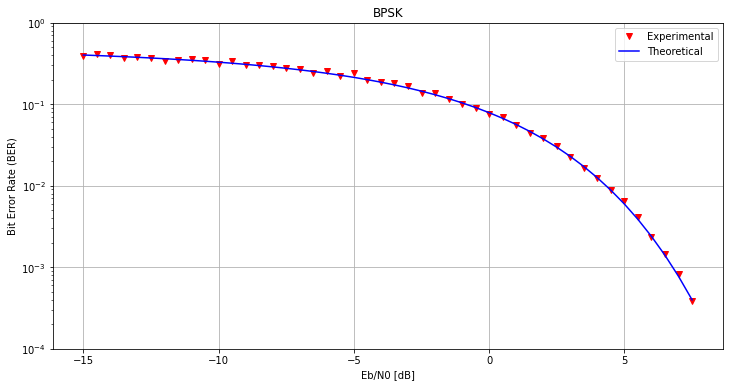

In [58]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_BPSK, p_e_BPSK, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_BPSK, get_ber_BPSK(eb_no_range_BPSK), color='b')

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("BPSK")
plt.legend(['Experimental', 'Theoretical'])
plt.grid()
plt.show()

## QPSK - Quadrature Phase-Shift Keying

First, let's create function **normalize()** for normalization of constellation power to 1

In [15]:
def normalize(constellation):
    n = np.sqrt(sum(abs(constellation)**2)/len(constellation))

    return constellation / n     

QPSK modulation differs from BPSK in that it also uses imaginary part for mapping bits to the points on the constellation diagram:

$00 \rightarrow \frac{A}{\sqrt{2}}+j\frac{A}{\sqrt{2}},\;\;01 \rightarrow -\frac{A}{\sqrt{2}}+j\frac{A}{\sqrt{2}},\;\;10 \rightarrow \frac{A}{\sqrt{2}}-j\frac{A}{\sqrt{2}},\;\;11 \rightarrow -\frac{A}{\sqrt{2}}-j\frac{A}{\sqrt{2}}$

The average signal power is equal to $A^2$

In our case, we choose $A = 1$ so that the average power of the signal is equal to 1

Note, that here we use the Gray coding to reduce the number of errors

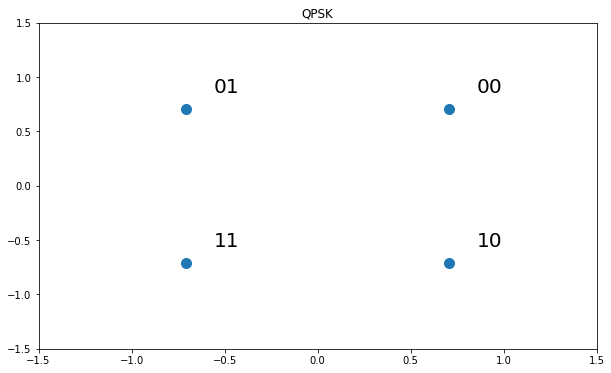

In [16]:
# Point index:     0    1    2    3
# Bit values:     00   01   10   11
# Complex num:   1+j  -1+j +1-j -1-j

QPSK = np.array([1+1j,  -1+1j,  +1-1j, -1-1j])
QPSK = normalize(QPSK)
QPSK_bits = ["00","01","10","11"]

plot_constellation(QPSK, QPSK_bits, "QPSK")

Carry out simulation for given range of SNR in dB

In [17]:
snr_range_QPSK = np.arange(-15, 11, 0.5)

p_e_QPSK = simulate(
    snr_range_QPSK,      # SNR values
    500,                  # Maximum error count
    lambda x: one_run(QPSK, x)  # Single test function
)

Now let's derive theoretical equation for BER(SNR)

QPSK can be considered as two BPSK signals: one along in-phase axis, another - along quadrature one. That is, one bit is conveyed using the in-phase component of the carrier (the cosine) while the other bit is conveyed using the quadrature phase (the sine component).

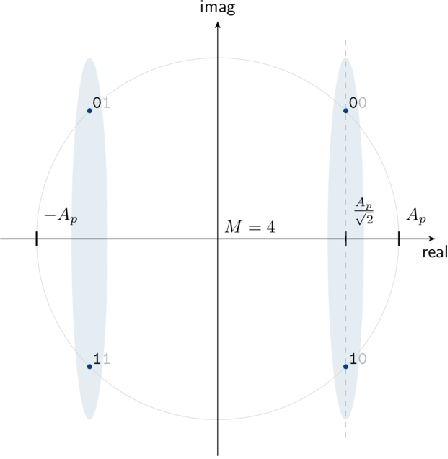

However, now the separation between adjacent points is $\sqrt{2}A$  compared to $2A$ in BPSK. It happens because the energy per sample is shared between real and imaginary component. Thus, error probability is $Q(\frac{A}{\sqrt{2}\sigma})$

$N_0 = 2\sigma^2$, $E_s = A^2$, $\frac{E_s}{N_0} = \frac{A^2}{2\sigma^2} \Rightarrow \frac{A}{\sigma} = \sqrt{\frac{2E_s}{N_0}} \Rightarrow BER = Q(\sqrt{\frac{E_s}{N_0}})$

However, in QPSK, each constellation point carries two bits of information, therefore, $E_s = 2E_b$ and $BER = Q(\sqrt{\frac{2E_b}{N_0}})$

In [18]:
def get_ber_QPSK(eb_no_db):
    eb_no_linear = 10 ** (eb_no_db / 10)
    return Q(np.sqrt(2*eb_no_linear))

Let's convert SNR in our range to $\frac{E_b}{N_0}$

In [19]:
eb_no_range_QPSK = snr_to_eb_no(snr_range_QPSK, QPSK)

Finally, let's compare experimental results with theoretical ones

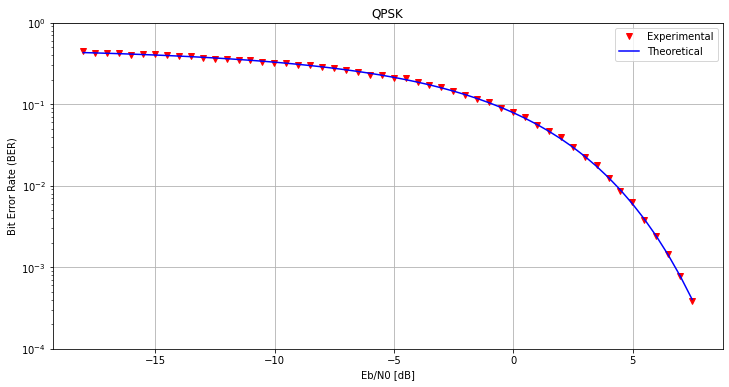

In [57]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_QPSK, p_e_QPSK, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_QPSK, get_ber_QPSK(eb_no_range_QPSK), color='b')

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("QPSK")
plt.legend(['Experimental', 'Theoretical'])
plt.grid()
plt.show()

Note that dependency of $BER$ on $\frac{E_s}{N_0}$ in the case of QPSK differs from the dependency in the case of BPSK. But if we move to the dependency of $BER$ on $\frac{E_b}{N_0}$, it is the same in both cases. The next plot can prove that fact

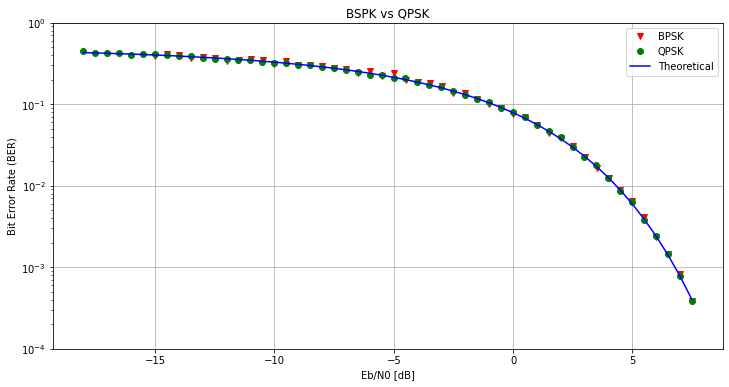

In [63]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_BPSK, p_e_BPSK, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_QPSK, p_e_QPSK, marker="o", markersize=6, linestyle = 'None', color="g")
plt.plot(eb_no_range_QPSK, get_ber_QPSK(eb_no_range_QPSK), color='b')

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("BSPK vs QPSK")
plt.legend(['BPSK', 'QPSK', 'Theoretical'])
plt.grid()
plt.show()

## ASK - Amplitude Shift Keying

ASK scheme is similar to BPSK in a sense that it uses only in-phase component of the carrier signal to convey information.

ASK4 has the following mapping of bits to the points on the constellation diagram:
$00 \rightarrow -3A,\;\;01 \rightarrow -A,\;\;11 \rightarrow A,\;\;10 \rightarrow 3A$

Recall, that we will choose $A$ so that the average power of the signal is equal to 1

Note, that here we still use the Gray coding to reduce the number of errors

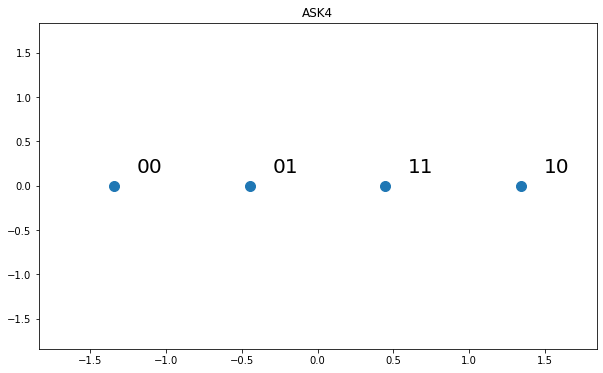

In [22]:
# First, let us apply the Gray coding
# Point index:     0    1    2    3
# Bit values:     00   01   10   11
# Complex num:   -3    -1   3     1
ASK4 = np.array([-3,  -1,  3, 1])
ASK4 = normalize(ASK4)
ASK4_bits = ["00", "01", "10", "11"]

plot_constellation(ASK4, ASK4_bits, "ASK4")

Carry out simulation for given range of SNR in dB

In [23]:
snr_range_ASK4 = np.arange(-15, 14, 0.5)

p_e_ASK4 = simulate(
    snr_range_ASK4,      # SNR values
    500,                  # Maximum error count
    lambda x: one_run(ASK4, x)  # Single test function
)

Now let's derive theoretical equation for BER(SNR)

Consider that $s=01$ was transmitted and calculate probabilities of making an error.

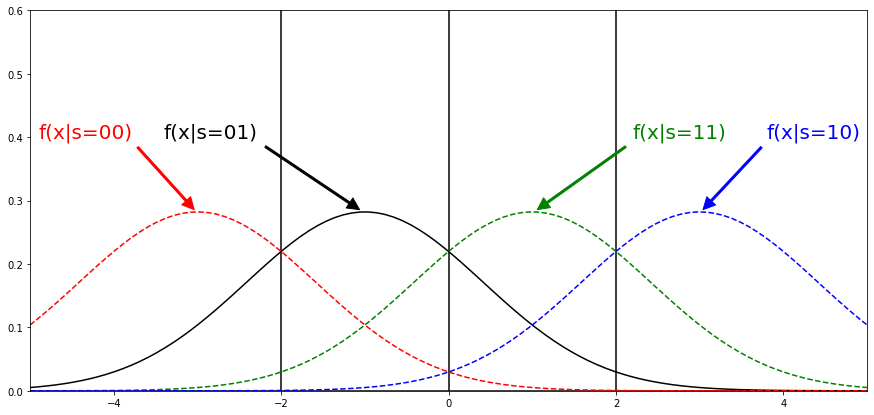

In [24]:
plt.figure(figsize=(15,7))
xmin = -5
xmax = 5
sigma = math.sqrt(2)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, -1, sigma), color="k")
plt.plot(x, stats.norm.pdf(x, -3, sigma), "--", color="red")
plt.plot(x, stats.norm.pdf(x, 1, sigma), "--", color="green")
plt.plot(x, stats.norm.pdf(x, 3, sigma), "--", color="blue")
plt.vlines(-2, 0, 0.6, "k")
plt.vlines(0, 0, 0.6, "k")
plt.vlines(2, 0, 0.6, "k")
plt.hlines(0, xmin, xmax, "k")

plt.ylim(0,0.6)
plt.xlim([xmin,xmax])

plt.annotate('f(x|s=00)', xy=(-3, 0.28), xytext=(-4.9, 0.4), color="red",
            arrowprops=dict(shrink=0.05, width=2, color="red"), size=20)

plt.annotate('f(x|s=01)', xy=(-1, 0.28), xytext=(-3.4, 0.4), color="k",
            arrowprops=dict(shrink=0.05, width=2, color="k"), size=20)

plt.annotate('f(x|s=11)', xy=(1, 0.28), xytext=(2.2, 0.4), color="green",
            arrowprops=dict(shrink=0.05, width=2, color="green"), size=20)

plt.annotate('f(x|s=10)', xy=(3, 0.28), xytext=(3.8, 0.4), color="blue",
            arrowprops=dict(shrink=0.05, width=2, color="blue"), size=20)
plt.show()

In ASK4, we make a desicion based on which range the real part of the received symbol falls into. Thus, we have three decision boundaries: $x=-2A$, $x=0$, $x=2A$.

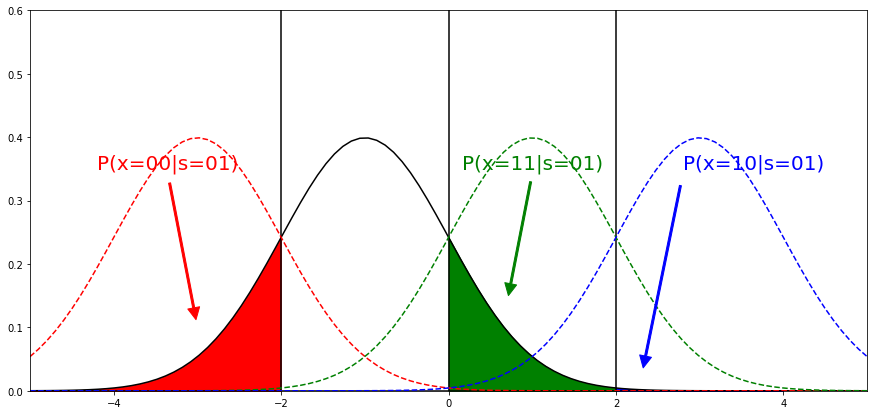

In [74]:
plt.figure(figsize=(15,7))
xmin = -5
xmax = 5
sigma = 1
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, -1, sigma), color="k")
plt.plot(x, stats.norm.pdf(x, -3, sigma), "--", color="red")
plt.plot(x, stats.norm.pdf(x, 1, sigma), "--", color="green")
plt.plot(x, stats.norm.pdf(x, 3, sigma), "--", color="blue")
plt.vlines(-2, 0, 0.6, "k")
plt.vlines(0, 0, 0.6, "k")
plt.vlines(2, 0, 0.6, "k")
plt.hlines(0, xmin, xmax, "k")

plt.ylim(0,0.6)
plt.xlim([xmin,xmax])

section = np.arange(-6, -2, 1/200.)
plt.fill_between(section,stats.norm.pdf(section, -1, sigma), color="red")
section = np.arange(0, 2, 1/200.)
plt.fill_between(section,stats.norm.pdf(section, -1, sigma), color="green")
section = np.arange(2, 4, 1/200.)
plt.fill_between(section,stats.norm.pdf(section, -1, sigma), color="blue")

plt.annotate('P(x=00|s=01)', xy=(-3, 0.1), xytext=(-4.2, 0.35), color="red",
            arrowprops=dict(color='red', shrink=0.05, width=2), size=20)

plt.annotate('P(x=11|s=01)', xy=(0.7, 0.14), xytext=(1, 0.35), color="green", ha='center',
            arrowprops=dict(color='green', shrink=0.05, width=2), size=20)

plt.annotate('P(x=10|s=01)', xy=(2.3, 0.02), xytext=(2.8, 0.35), color="blue",
            arrowprops=dict(color='blue', shrink=0.05, width=2), size=20)

plt.show()

The probability of receiving $x=00$ when $s=01$ was transmitted is the red shaded area:
$P(x=00|s=01) = \int_{-\infty}^{-2A} f(x|s=01) \,dx = \frac{1}{\sqrt{2\pi \sigma^2}} \int_{-\infty}^{-2A} exp(-\frac{(u+A)^2}{2\sigma^2})\,du = \Big[ \frac{u+A}{\sigma}=z, du = \sigma dz \Big] = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\frac{-A}{\sigma}} exp(-\frac{z^2}{2})\,dz = $

$=\frac{1}{\sqrt{2\pi}}\int_{\frac{A}{\sigma}}^{\infty } exp(-\frac{z^2}{2})\,dz =
Q(\frac{A}{\sigma})$

The probability of receiving $x=10$ when $s=01$ was transmitted is the blue shaded area:
$P(x=00|s=01) = \int_{2A}^{\infty} f(x|s=01) \,dx = \frac{1}{\sqrt{2\pi \sigma^2}} \int_{2A}^{\infty} exp(-\frac{(u+A)^2}{2\sigma^2})\,du = \Big[ \frac{u+A}{\sigma}=z, du = \sigma dz \Big] = \frac{1}{\sqrt{2\pi}}\int_{\frac{3A}{\sigma}}^{\infty} exp(-\frac{z^2}{2})\,dz = Q(\frac{3A}{\sigma}),$

The probability of receiving $x=11$ when $s=01$ was transmitted is the green shaded area:
$P(x=00|s=01) = \int_{0}^{2A} f(x|s=01) \,dx = \frac{1}{\sqrt{2\pi \sigma^2}} \int_{0}^{2A} exp(-\frac{(u+A)^2}{2\sigma^2})\,du = \Big[ \frac{u+A}{\sigma}=z, du = \sigma dz \Big] = \frac{1}{\sqrt{2\pi}}\int_{\frac{A}{\sigma}}^{\frac{3A}{\sigma}} exp(-\frac{z^2}{2})\,dz = $

$=\frac{1}{\sqrt{2\pi}}\int_{\frac{A}{\sigma}}^{\infty} exp(-\frac{z^2}{2})\,dz - 
\frac{1}{\sqrt{2\pi}}\int_{\frac{3A}{\sigma}}^{\infty} exp(-\frac{z^2}{2})\,dz = Q(\frac{A}{\sigma}) - Q(\frac{3A}{\sigma})$

Bit error rate during transmission $s=01$ is the mathematical expectation of the number of errors $n_e$ in this case divided by total number of transmitted bits: $BER(s=01) = \frac{E[n_e]}{n}$

In ASK4: $n=2$, while $E[n_e]=1\times P(x=00|s=01) + 2 \times P(x=00|s=01) + 1 \times P(x=00|s=01)$

Therefore, $BER(s=01) = \frac{1}{2} \big[2Q(\frac{A}{\sigma})+Q(\frac{3A}{\sigma})\big]$

Similarly, $BER(s=00) = BER(s=10) = \frac{1}{2} \big[Q(\frac{A}{\sigma})+Q(\frac{3A}{\sigma})-Q(\frac{5A}{\sigma})\big]$, while

$BER(s=00) = BER(s=01) = \frac{1}{2} \big[2Q(\frac{A}{\sigma})+Q(\frac{3A}{\sigma})\big]$

Since each $s$ is transmitted equiprobably, final $BER$ is just the average of $BER(s)$:

$BER = \frac{1}{4}\big[BER(s=00)+BER(s=01)+BER(s=10)+BER(s=11)\big] = \frac{3}{4}Q(\frac{A}{\sigma})+\frac{1}{2}Q(\frac{3A}{\sigma})-\frac{1}{4}Q(\frac{5A}{\sigma})$

The average signal power in ASK4 is given by the following expression:

$E_s = \frac{1}{4}\big[A^2+(3A)^2+(-A)^2+(-3A)^2\big]=5A^2$

Each symbol in ASK4 carries 2 bits, therefore, $E_b = \frac{E_s}{2}=\frac{5}{2}A^2$

Noise power spectral density $N_0 = 2\sigma^2$, so $\frac{E_b}{N_0} = \frac{5A^2}{4\sigma^2}$
and $\frac{A}{\sigma} = \sqrt{\frac{4E_b}{5N_0}}$

Finally, we have $BER = \frac{3}{4}Q(\sqrt{\frac{4E_b}{5N_0}})+\frac{1}{2}Q(\sqrt{\frac{36E_b}{5N_0}})-\frac{1}{4}Q(\sqrt{\frac{20E_b}{N_0}})$

In [26]:
def get_ber_ASK4(eb_no_db):
    eb_no_linear = 10 ** (eb_no_db / 10)
    return 3/4 * Q(np.sqrt(4/5*eb_no_linear)) + \
        1/2*Q(np.sqrt(36/5*eb_no_linear)) - 1/4 * Q(np.sqrt(20*eb_no_linear))

Let's convert SNR in our range to $\frac{E_b}{N_0}$

In [27]:
eb_no_range_ASK4 = snr_to_eb_no(snr_range_ASK4, ASK4)

Finally, let's compare experimental results with theoretical ones

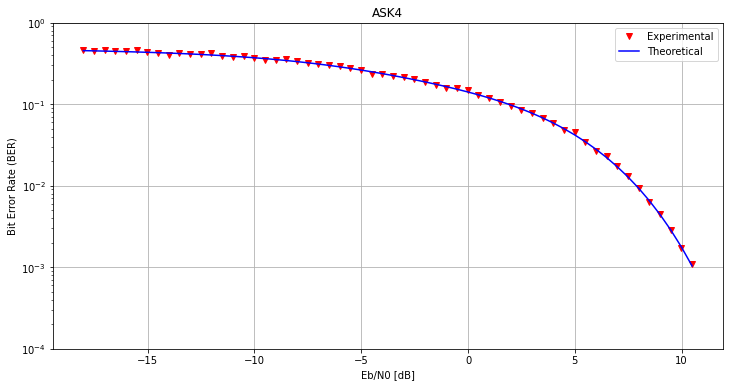

In [64]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_ASK4, p_e_ASK4, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_ASK4, get_ber_ASK4(eb_no_range_ASK4), color='b')

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("ASK4")
plt.legend(['Experimental', 'Theoretical'])
plt.grid()
plt.show()

## QAM - Quadrature Amplitude Modulation

QAM16 modulation differs from ASK4 in that it also uses imaginary part for mapping bits to the points on the constellation diagram:

$0000 \rightarrow -3-3j, \;\; 0001\rightarrow -3-1j, \;\; 0010\rightarrow -3+3j, 0011\;\; \rightarrow -3+1j$ and so on.

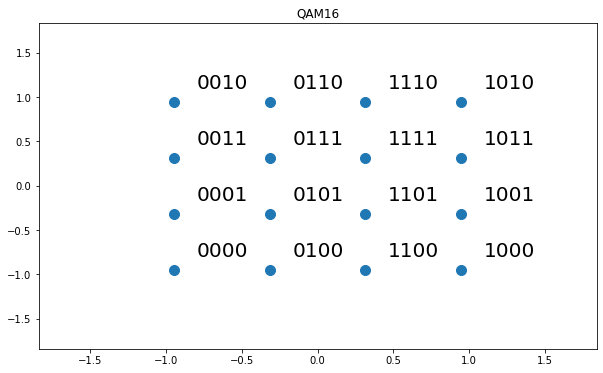

In [29]:
QAM16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, \
                     +3-3j, +3-1j, +3+3j, +3+1j, +1-3j, +1-1j,  +1+3j, +1+1j])
QAM16 = normalize(QAM16)
QAM16_bits = ["0000", "0001", "0010", "0011", "0100", "0101", "0110", "0111", \
        "1000", "1001", "1010", "1011", "1100", "1101", "1110", "1111"]
    
plot_constellation(QAM16, QAM16_bits, "QAM16")

Carry out simulation for given range of SNR in dB

In [30]:
snr_range_QAM16 = np.arange(-15, 18, 0.5)

p_e_QAM16 = simulate(
    snr_range_QAM16,      # SNR values
    500,                  # Maximum error count
    lambda x: one_run(QAM16, x)  # Single test function
)

Now let's derive theoretical equation for BER(SNR)

Derivation of BER for QAM16 is based on the derivation for ASK4 just the same as derivation of BER for QPSK is based on the one for BPSK.

QAM16 can be considered as two ASK4 signals: one along in-phase axis, another - along quadrature one. That is, one bit is conveyed using the in-phase component of the carrier (the cosine) while the other bit is conveyed using the quadrature phase (the sine component).



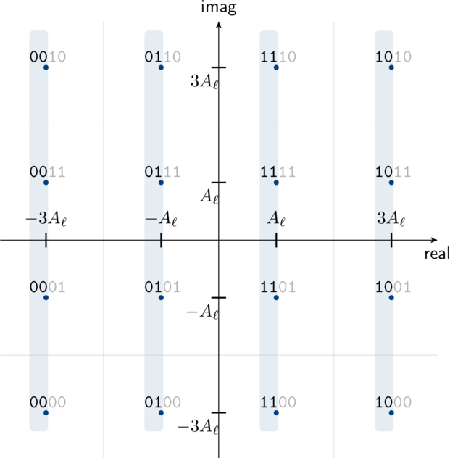

Note that here we chose constellation points in such a way that the separation between adjacent points is just the same as in ASK4: $2A$.

Thus, we can take formula for the dependency of $BER$ on $\frac{A}{\sigma}$ from the case of ASK4: $BER = \frac{3}{4}Q(\frac{A}{\sigma})+\frac{1}{2}Q(\frac{3A}{\sigma})-\frac{1}{4}Q(\frac{5A}{\sigma})$.

However, now the average signal power is $E_s = 10A^2$ and the average power per bit is $E_b = \frac{E_s}{4}=\frac{5}{2}A^2$ since in QAM16 every point on the constellation diagram carries $4$ bits.

$N_0=2\sigma^2$, $\frac{E_b}{N_0} = \frac{5A^2}{4\sigma^2} \Rightarrow \frac{A}{\sigma} = \sqrt{\frac{4E_b}{5N_0}}$

Finally, we have the following equation for $BER$:

$BER = \frac{3}{4}Q(\sqrt{\frac{4E_b}{5N_0}})+\frac{1}{2}Q(\sqrt{\frac{36E_b}{5N_0}})-\frac{1}{4}Q(\sqrt{\frac{20E_b}{N_0}})$

In [31]:
def get_ber_QAM16(eb_no_db):
    eb_no_linear = 10 ** (eb_no_db / 10)
    return 3/4 * Q(np.sqrt(4/5*eb_no_linear)) + \
        1/2*Q(np.sqrt(36/5*eb_no_linear)) - 1/4 * Q(np.sqrt(20*eb_no_linear))

Let's convert SNR in our range to $\frac{E_b}{N_0}$

In [32]:
eb_no_range_QAM16 = snr_to_eb_no(snr_range_QAM16, QAM16)

Finally, let's compare experimental results with theoretical ones

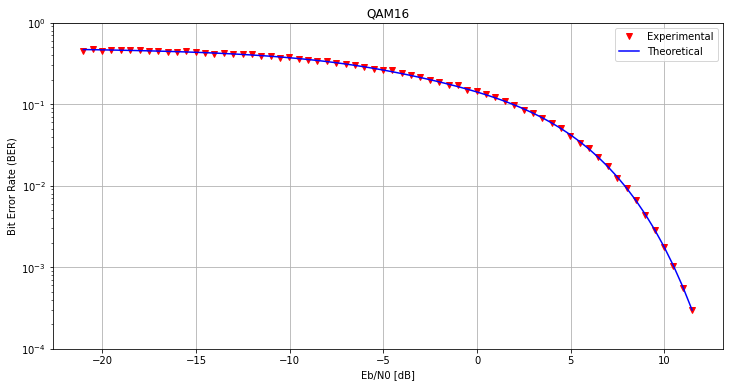

In [65]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_QAM16, p_e_QAM16, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_QAM16, get_ber_QAM16(eb_no_range_QAM16), color='b')

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("QAM16")
plt.legend(['Experimental', 'Theoretical'])
plt.grid()
plt.show()

It can be observed that theoretical curve perfectly matches curve with experimental results because
the derived equation is exact

Note that there is also approximate formula for symbol error probability $P_s$:
$P_s = \frac{3}{2}erfc\big(\sqrt{\frac{E_s}{10N_0}}\big)$
derived for instance [here](http://www.dsplog.com/2007/12/09/symbol-error-rate-for-16-qam/).

Given that $E_s = 4E_b, erfc(z) = 1 - erf(z), Q(x) = \frac{1}{2}erfc(\frac{x}{\sqrt{2}}),$ we have 
$P_s = 3Q\big(\sqrt{\frac{4E_b}{5N_0}}\big)$

Bit error probability $BER = \frac{P_s}{4} = \frac{3}{4}Q\big(\sqrt{\frac{4E_b}{5N_0}}\big)$

In [34]:
def get_ber_QAM16_approximated(eb_no_db):
    eb_no_linear = 10 ** (eb_no_db / 10)
    return 3/4 *  Q(np.sqrt(4/5*(eb_no_linear)))

Let's try to use this equation for comparison with theoretical results

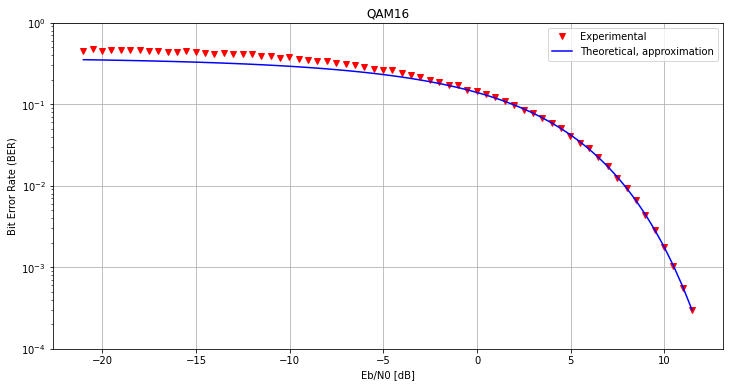

In [66]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_QAM16, p_e_QAM16, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_QAM16, get_ber_QAM16_approximated(eb_no_range_QAM16), color="b")

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("QAM16")
plt.legend(['Experimental', 'Theoretical, approximation'])
plt.grid()
plt.show()

As we can see, this approximation does not work properly with low level of $\frac{E_b}{N_0}$ because this equation does not take into account the fact that multiple errors may occur

Also note that dependency of $BER$ on $\frac{E_s}{N_0}$ in the case of QAM16 differs from the dependency in the case of ASK4. But if we move to the dependency of $BER$ on $\frac{E_b}{N_0}$, it is the same in both cases. The next plot can prove that fact

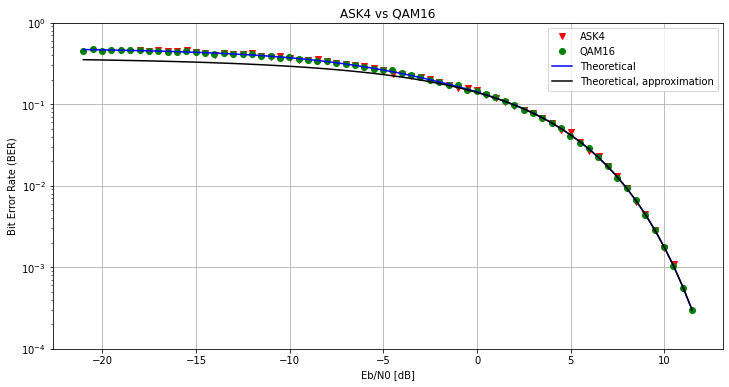

In [67]:
plt.figure(figsize=(12,6))
plt.plot(eb_no_range_ASK4, p_e_ASK4, marker="v", markersize=6, linestyle = 'None', color="r")
plt.plot(eb_no_range_QAM16, p_e_QAM16, marker="o", markersize=6, linestyle = 'None', color="g")
plt.plot(eb_no_range_QAM16, get_ber_QAM16(eb_no_range_QAM16), color="b")
plt.plot(eb_no_range_QAM16, get_ber_QAM16_approximated(eb_no_range_QAM16), color="k")

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.yticks([1,1e-1,1e-2,1e-3,1e-4])
plt.title("ASK4 vs QAM16")
plt.legend(['ASK4', 'QAM16', 'Theoretical','Theoretical, approximation'])
plt.grid()
plt.show()